<a href="https://colab.research.google.com/github/jiunndar/tensorflow-tutorial/blob/main/sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


# FCC

In [3]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
  #pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [4]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-05-05 12:26:09--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  1.14MB/s    in 0.3s    

2021-05-05 12:26:11 (1.14 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-05-05 12:26:11--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

# EDA

In [5]:
print(train_file_path)
print(test_file_path)

train-data.tsv
valid-data.tsv


In [6]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [7]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [8]:
print(len(df_train))
print(len(df_test))

4179
1392


In [15]:
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0.5, 1.0, 'Number of ham and spam messages')

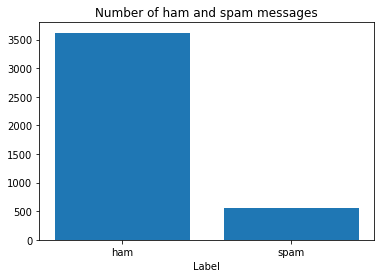

In [16]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [28]:
df_train.describe()

,y,x
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [30]:
# Get all the ham and spam emails
ham_msg = df_train[df_train.y =='ham']
spam_msg = df_train[df_train.y=='spam']


In [35]:
spam_msg

,y,x
8,spam,urgent! call 09066350750 from your landline. y...
16,spam,bored housewives! chat n date now! 0871750.77....
20,spam,message important information for o2 user. tod...
37,spam,free for 1st week! no1 nokia tone 4 ur mobile ...
39,spam,you have 1 new voicemail. please call 08719181503
...,...,...
4164,spam,free msg: single? find a partner in your area!...
4165,spam,free2day sexy st george's day pic of jordan!tx...
4167,spam,you are a winner you have been specially selec...
4176,spam,free entry into our £250 weekly competition ju...


In [38]:
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.x.to_numpy().tolist())
#spam_msg_text = " ".join(spam_msg.x.to_numpy().tolist()

In [39]:
ham_msg_text

"ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it. you can never do nothing now u sound like manky scouse boy steve,like! i is travelling on da bus home.wot has u inmind 4 recreation dis eve? mum say we wan to go then go... then she can shun bian watch da glass exhibition... never y lei... i v lazy... got wat? dat day ü send me da url cant work one... in xam hall boy asked girl tell me the starting term for dis answer i can den manage on my own after lot of hesitation n lookin around silently she said the! intha ponnungale ipaditan;) genius what's up. how your brother. pls send his number to my skype. they finally came to fix the ceiling. now that you have started dont stop. just pray for more good ideas and anything i see that can help you guys i.ll forward you a link. hello darlin ive finished college now so txt me when u finish if u can love kate xxx aiyo cos i sms ü then ü neva reply so

In [42]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

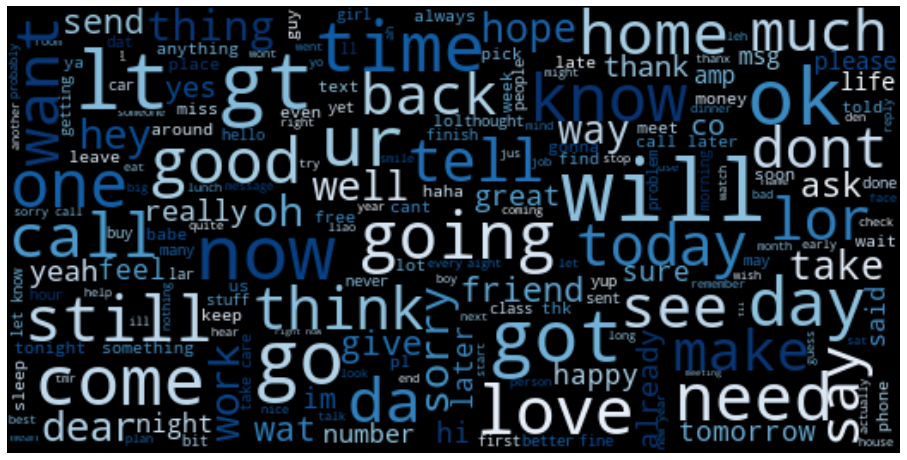

In [43]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [40]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 

15.473887814313347

In [17]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [18]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [19]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [20]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [21]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [23]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

In [24]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [25]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [26]:
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

# Working code / Model

In [103]:


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[max_len]),
    tf.keras.layers.Embedding(max_words, 50, input_length=max_len),
    tf.keras.layers.LSTM(64),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer= tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 50)           50000     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [104]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
27/27 [==============================] - 19s 640ms/step - loss: 0.5799 - accuracy: 0.7924 - val_loss: 0.3016 - val_accuracy: 0.8612
Epoch 2/10
27/27 [==============================] - 17s 627ms/step - loss: 0.2390 - accuracy: 0.8886 - val_loss: 0.0936 - val_accuracy: 0.9797
Epoch 3/10
27/27 [==============================] - 17s 630ms/step - loss: 0.0583 - accuracy: 0.9862 - val_loss: 0.0526 - val_accuracy: 0.9868
Epoch 4/10
27/27 [==============================] - 17s 628ms/step - loss: 0.0320 - accuracy: 0.9914 - val_loss: 0.0469 - val_accuracy: 0.9880
Epoch 5/10
27/27 [==============================] - 17s 634ms/step - loss: 0.0246 - accuracy: 0.9947 - val_loss: 0.0408 - val_accuracy: 0.9904
Epoch 6/10
27/27 [==============================] - 17s 625ms/step - loss: 0.0146 - accuracy: 0.9968 - val_loss: 0.0375 - val_accuracy: 0.9904
Epoch 7/10
27/27 [==============================] - 17s 631ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.0357 - val_accuracy: 0.9916

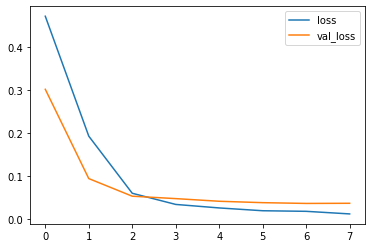

In [105]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

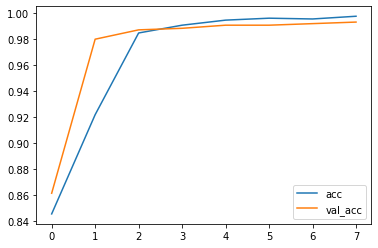

In [106]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [83]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [107]:
s = model.evaluate(preprocessing(df_test['x']), y_test)

44/44 [==============================] - 3s 64ms/step - loss: 0.0434 - accuracy: 0.9842


In [108]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.043, Accuracy: 0.984


In [109]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

(0.99141026, 'spam')


# Validation

In [110]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
